In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [2]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_nftc/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [3]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,1.473332e+08,5.094727e+06,8.082051e+02,5.028689e-01,4.028818e-01,9.854712e-02,3.752564e-01,5.918652e-02,4.195026e-01,1.184329e-01,...,1.145499e-02,1.968431e-02,7.960149e-02,1.344227e-01,9.530649e-03,1.751597e-02,8.878922e-02,7.431632e-02,3.897225e-02,5.331061e-02
std,9.952986e+07,7.972087e+06,2.292125e+03,4.710872e-01,4.523492e-01,2.907154e-01,4.479614e-01,2.284392e-01,2.256374e-01,7.151420e-02,...,5.399123e-02,8.007008e-02,1.179461e-01,1.749526e-01,5.258238e-02,8.241773e-02,1.050750e-01,9.861962e-02,9.868933e-02,1.123964e-01
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.926878e+07,4.672090e+05,5.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.368196e+08,1.634092e+06,1.990000e+02,6.774194e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433434e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,5.416341e-02,3.541864e-02,0.000000e+00,0.000000e+00
75%,2.260676e+08,6.254382e+06,6.840000e+02,1.000000e+00,9.390244e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.860562e-01,1.505134e-01,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,1.365586e-01,1.118571e-01,0.000000e+00,4.670041e-02
max,3.617734e+08,5.973444e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [5]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=3.7022064651322837


### Sample only PRs by non-first-time contributors

In [6]:
# Filters data
df = df[df[ftc_key] == False]
df = df.drop([ftc_key], axis=1)
independent_fields.remove(ftc_key)
print(f"{len(df)=}")

# Recalculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

# Resets indices.
df = df.reset_index(drop=True)
print(independent_fields)

df.describe()

len(df)=789271
class_imbalance=6.004410642338617
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosys

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,7.892710e+05,7.892710e+05,789271.000000,789271.000000,789271.000000,789271.000000,789271.000000,789271.000000,789271.000000,789271.000000,...,789271.000000,789271.000000,789271.000000,789271.000000,789271.000000,789271.000000,789271.000000,789271.000000,789271.000000,789271.000000
mean,1.613827e+08,5.072829e+06,929.774379,0.774892,0.477268,0.138904,0.439467,0.077761,0.380527,0.124918,...,0.016151,0.027668,0.091433,0.155949,0.012426,0.022727,0.114327,0.097278,0.053920,0.073918
std,9.888003e+07,7.946490e+06,2540.734633,0.362191,0.457023,0.336886,0.456671,0.259143,0.217223,0.075807,...,0.063854,0.093937,0.124397,0.183594,0.060233,0.093768,0.109725,0.104954,0.114497,0.128890
min,6.870000e+02,4.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.606350e+07,4.531855e+05,68.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.198054,0.075257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028509,0.016304,0.000000,0.000000
50%,1.563307e+08,1.606283e+06,255.000000,0.977273,0.545455,0.000000,0.083333,0.000000,0.393442,0.075257,...,0.000000,0.000000,0.000000,0.077533,0.000000,0.000000,0.086562,0.064877,0.000000,0.000000
75%,2.409820e+08,6.201287e+06,807.000000,1.000000,0.967742,0.000000,0.960612,0.000000,0.545802,0.150513,...,0.000000,0.000000,0.141667,0.277955,0.000000,0.000000,0.168355,0.143526,0.038869,0.105939
max,3.617734e+08,5.943086e+07,82974.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.993928,...,1.000000,1.000000,0.854348,0.886162,0.999796,1.000000,1.000000,1.000000,1.000000,1.000000


## Model Creation

In [7]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


### Full Model

In [8]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43
random_state=43
random_state=43
random_state=43random_state=43

metrics={'accuracy': 0.9314936586972772, 'precision': 0.9431329861407552, 'recall': 0.9791629734680612, 'f1': 0.9608103210842937}

Confusion matrix:
[[ 14477   7993]
 [  2821 132563]]

Classification report:
              precision    recall  f1-score   support

       False       0.84      0.64      0.73     22470
        True       0.94      0.98      0.96    135384

    accuracy                           0.93    157854
   macro avg       0.89      0.81      0.84    157854
weighted avg       0.93      0.93      0.93    157854

metrics={'accuracy': 0.9310379778911025, 'precision': 0.9432811387900356, 'recall': 0.9784640600082689, 'f1': 0.960550538507255}

Confusion matrix:
[[ 14438   7969]
 [  2917 132531]]

Classification report:
              precision    recall  f1-score   support

       False       0.83      0.64      0.73     22407
        True       0.94      0.98      0.96    135448

    accuracy  

### Control + Intra-project Model

In [9]:
from python_proj.utils.util import get_matching

ci_re = r".*(Control|Intra).*"
contr_with_intra = list(get_matching(independent_fields, ci_re))
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']


random_state=45
random_state=45
random_state=45
random_state=45random_state=45

metrics={'accuracy': 0.9254885812929587, 'precision': 0.9412134773625777, 'recall': 0.9738229964125892, 'f1': 0.957240597075696}

Confusion matrix:
[[ 14437   8223]
 [  3539 131656]]

Classification report:
              precision    recall  f1-score   support

       False       0.80      0.64      0.71     22660
        True       0.94      0.97      0.96    135195

    accuracy                           0.93    157855
   macro avg       0.87      0.81      0.83    157855
weighted avg       0.92      0.93      0.92    157855

metrics={'accuracy': 0.9251333510712431, 'precision': 0.9405495313492716, 'recall': 0.9741949794816814, 'f1': 0.9570766503951651}

Confusion matrix:
[[ 14281   8328]
 [  3490 131755]]

Classification report:
              precision    recall  f1-score   support

       False       0.80      0.63      0.71     22609
        True       0.94      0.97      0.96    135245

    accuracy  

### Collaboration and Ecosystem Model

In [10]:
from python_proj.utils.util import get_non_matching

non_control_intra_fields = list(get_non_matching(independent_fields, ci_re))
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + DependencyEcosystem

random_state=47
random_state=47
random_state=47random_state=47

random_state=47
metrics={'accuracy': 0.8542007171183499, 'precision': 0.8698517298187809, 'recall': 0.9758621964292316, 'f1': 0.9198125533508702}

Confusion matrix:
[[  2839  19750]
 [  3265 132000]]

Classification report:
              precision    recall  f1-score   support

       False       0.47      0.13      0.20     22589
        True       0.87      0.98      0.92    135265

    accuracy                           0.85    157854
   macro avg       0.67      0.55      0.56    157854
weighted avg       0.81      0.85      0.82    157854

metrics={'accuracy': 0.8538912292927053, 'precision': 0.8695640726918494, 'recall': 0.976011938622478, 'f1': 0.9197181921973767}

Confusion matrix:
[[  2679  19817]
 [  3247 132112]]

Classification report:
              precision    recall  f1-score   support

       False       0.45      0.12      0.19     22496
        True       0.87      0.98      0.92    135359

    accuracy  

## Feature Explanation and Evaluation

### Partial Dependence Plots

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]

random_state=49
metrics={'accuracy': 0.9313420544170283, 'precision': 0.9433198092390918, 'recall': 0.9787669310645337, 'f1': 0.9607165122584199}

Confusion matrix:
[[ 14490   7963]
 [  2875 132527]]

Classification report:
              precision    recall  f1-score   support

       False       0.83      0.65      0.73     22453
        True       0.94      0.98      0.96    135402

    accuracy                           0.93    157855
   macro avg       0.89      0.81      0.84    157855
weighted avg       0.93      0.93      0.93    157855



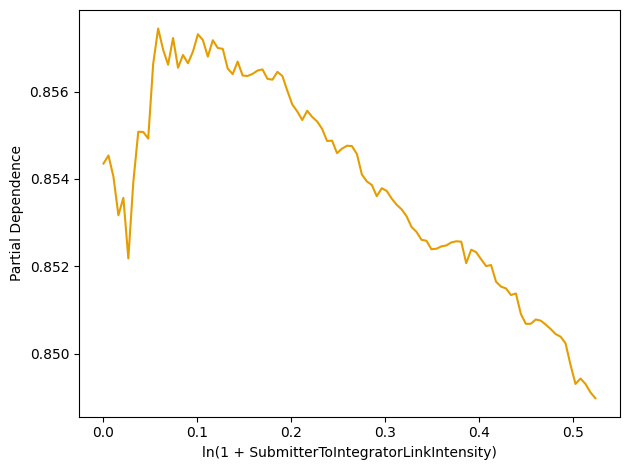

In [12]:
from python_proj.modelling.notebooks.random_forest.rf_functions import create_model
from python_proj.modelling.notebooks.random_forest.pd_functions import (
    create_partial_dependence_plots,
)

full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

output_path = f"{figure_base_path}/partial-dependence/"
create_partial_dependence_plots(full_rf_model, test_predictors, output_path)

### Mean decrease in Impurity

/tmp/ipykernel_6303/1648129876.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


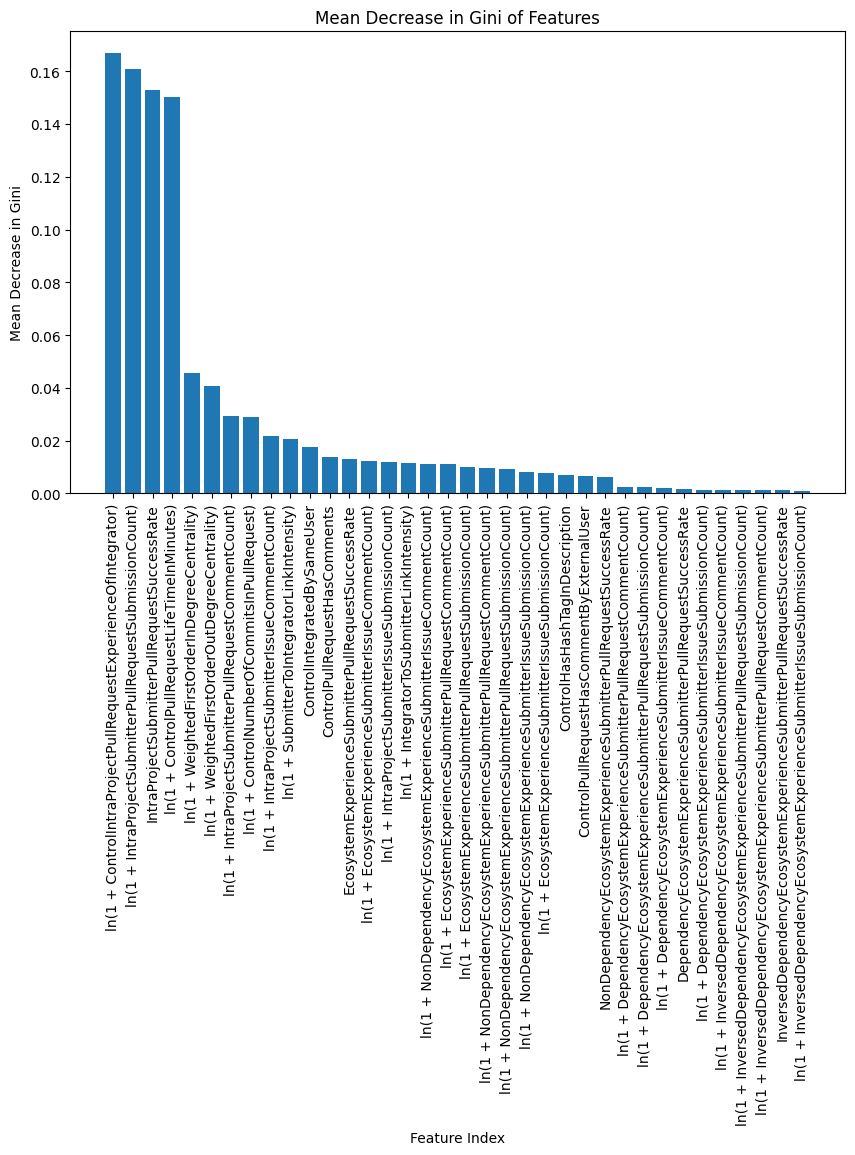

In [13]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

In [14]:
# Stores feature importances in file.
output_file = f"{figure_base_path}/feature_importance.txt"
with open(output_file, "w+", encoding="utf-8") as output_file:
    for field, importance in zip(ordererd_columns, sorted_importances):
        entry = f"{field}: {importance}"
        output_file.write(entry)
        print(entry)

ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.1667717917181565
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.16075906949586538
IntraProjectSubmitterPullRequestSuccessRate: 0.15279329196829639
ln(1 + ControlPullRequestLifeTimeInMinutes): 0.1502257971654223
ln(1 + WeightedFirstOrderInDegreeCentrality): 0.045694943209184
ln(1 + WeightedFirstOrderOutDegreeCentrality): 0.04065582302910574
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.02913752167387933
ln(1 + ControlNumberOfCommitsInPullRequest): 0.028816612352489928
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.021879144356247715
ln(1 + SubmitterToIntegratorLinkIntensity): 0.020595389126178913
ControlIntegratedBySameUser: 0.017590938513538767
ControlPullRequestHasComments: 0.013946214309967933
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.01285549869439632
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.012412040919596542
ln(1 + IntraProjectSubmitterIssueSubmissionCount): 0.01203

### Variable Group Ablation Studies

Performs an ablation and a reverse ablation study using different feature groups:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

_Note: the terms "cluster" and "feature groups" are synonymous in this context._

In [15]:
from python_proj.utils.util import get_matching

# Generates variable groups

var_group_regex_patterns = [
    ("control", r".*Control.*"),
    ("intra", r"^(?!.*Control).*(?=Intra).*"),
    ("eco", r"^(?!.*Dependency).*(?=Ecosystem).*"),
    ("deco", r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    ("ideco", r".*(?=Inverse).*"),
    ("ndeco", r".*(?=NonDependency).*"),
    ("coll", r".*(Weighted|LinkIntensity).*"),
]

var_groups = [
    (name, list(get_matching(independent_fields, pattern)))
    for name, pattern in var_group_regex_patterns
]

#### Regular Ablation
Creates models with subsets of the features to test their impact on the predictions in isolation.

In [16]:
abl_results = dict()

for cluster_name, cluster in var_groups:
    used_fields = list([field for field in independent_fields if field not in cluster])
    print(
        f'Ablation with "{cluster_name}", excluding: {list(cluster)}, including: {used_fields}.'
    )

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, used_fields, k, pr_merged_key, seed_counter
    )
    abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Ablation with "control", excluding: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'], including: ['IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosys

random_state=50
random_state=50
random_state=50
random_state=50
random_state=50
metrics={'accuracy': 0.8698607574087448, 'precision': 0.8869150312702179, 'recall': 0.9722014966720102, 'f1': 0.9276020172616132}

Confusion matrix:
[[  5707  16780]
 [  3763 131604]]

Classification report:
              precision    recall  f1-score   support

       False       0.60      0.25      0.36     22487
        True       0.89      0.97      0.93    135367

    accuracy                           0.87    157854
   macro avg       0.74      0.61      0.64    157854
weighted avg       0.85      0.87      0.85    157854

metrics={'accuracy': 0.869049881536103, 'precision': 0.8856873378920066, 'recall': 0.9726048679440704, 'f1': 0.9271134147846476}

Confusion matrix:
[[  5716  16968]
 [  3703 131467]]

Classification report:
              precision    recall  f1-score   support

       False       0.61      0.25      0.36     22684
        True       0.89      0.97      0.93    135170

    accuracy  

In [17]:
# Prints summarized results again for clarity.
print("Regular cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Regular cluster ablation results:
Cluster 'control':
f1_scores=[0.9276020172616132, 0.9271134147846476, 0.927112715784723, 0.9284294374735654, 0.9279539311151758]
f1_mean=0.9276423032839449, f1_std=0.000505668085859414

Cluster 'intra':
f1_scores=[0.9370236290682121, 0.9366746141655841, 0.9369635164459267, 0.9378688203098535, 0.936584426285058]
f1_mean=0.937023001254927, f1_std=0.0004544601805537111

Cluster 'eco':
f1_scores=[0.9602501959190782, 0.9609253231454028, 0.9606050827238874, 0.9594793151862776, 0.9606269542501658]
f1_mean=0.9603773742449624, f1_std=0.0004974080271419089

Cluster 'deco':
f1_scores=[0.9603112784079587, 0.960689802525558, 0.9601506027380334, 0.960731275744039, 0.9607257985560902]
f1_mean=0.9605217515943358, f1_std=0.00024323942242695964

Cluster 'ideco':
f1_scores=[0.9606234112839183, 0.9612215888487592, 0.9604155406998465, 0.9603611044696098, 0.9600745835509895]
f1_mean=0.9605392457706247, f1_std=0.00038356854822205096

Cluster 'ndeco':
f1_scores=[0.95987934072

#### Reverse ablation

Performs a reverse ablation study, such that models are created using ONLY the subset of variables.

In [18]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups:
    print(f'Reverse ablation with "{cluster_name}", including: {list(cluster)}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Reverse ablation with "control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].


random_state=64
random_state=64
random_state=64
random_state=64
random_state=64
metrics={'accuracy': 0.8610551522292752, 'precision': 0.896124031007752, 'recall': 0.9478559556786703, 'f1': 0.9212643368693123}

Confusion matrix:
[[  7605  14874]
 [  7059 128316]]

Classification report:
metrics={'accuracy': 0.8605619080802002, 'precision': 0.8961417910968705, 'recall': 0.947361041414529, 'f1': 0.921039887215213}

Confusion matrix:
[[  7469  14878]
 [  7133 128375]]

Classification report:
              precision    recall  f1-score   support

       False       0.52      0.34      0.41     22479
        True       0.90      0.95      0.92    135375

    accuracy                           0.86    157854
   macro avg       0.71      0.64      0.67    157854
weighted avg       0.84      0.86      0.85    157854

              precision    recall  f1-score   support

       False       0.51      0.33      0.40     22347
        True       0.90      0.95      0.92    135508

    accuracy    

In [19]:
# Prints summarized results again for clarity.
print("Reverse cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Reverse cluster ablation results:
Cluster 'control':
f1_scores=[0.9212643368693123, 0.921039887215213, 0.9210640674325979, 0.920057664031521, 0.9214725071235296]
f1_mean=0.9209796925344348, f1_std=0.0004867787382008364

Cluster 'intra':
f1_scores=[0.9243018928919046, 0.9249569828282473, 0.9247520301216668, 0.925098462197894, 0.923963538482082]
f1_mean=0.9246145813043588, f1_std=0.0004223511571643475

Cluster 'eco':
f1_scores=[0.9200838093130679, 0.9213473835402656, 0.9197998194639948, 0.9197907554860993, 0.920757898810902]
f1_mean=0.9203559333228659, f1_std=0.0006078305479429476

Cluster 'deco':
f1_scores=[0.9240865300940856, 0.9216092708889163, 0.9219328058646133, 0.9227042742401104, 0.9228850707054832]
f1_mean=0.9226435903586416, f1_std=0.0008624501995950643

Cluster 'ideco':
f1_scores=[0.9223525230987917, 0.9232785810838487, 0.9228294282396339, 0.9225934276149483, 0.922393057263906]
f1_mean=0.9226894034602257, f1_std=0.00033978170047729346

Cluster 'ndeco':
f1_scores=[0.920728443199

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [20]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.8572328135710041.
{
    "accuracy": 0.7553894396756518,
    "precision": 0.857616848328099,
    "recall": 0.8571291413716193,
    "f1": 0.8573729254932091
}


In [21]:
import datetime

print(datetime.datetime.now())

2024-01-31 15:11:55.141509
